# Exploratory Data Analysis: Financial Guidance Extraction Pipeline

This notebook performs EDA on the `guidance` table in `finance_data.db` to assess whether the extraction pipeline produces reasonable, high-quality output.

**Objectives:**
- Understand the structure and distribution of extracted guidance data
- Identify data quality issues (missing values, outliers, inconsistencies)
- Visualize key patterns in financial guidance extraction
- Assess pipeline output quality for thesis documentation

## 1. Import Required Libraries

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure visualization style for thesis-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Data from SQLite Database

Load the `guidance` table and join with `contents` to include publication dates for temporal analysis.

In [4]:
# Connect to the SQLite database
db_path = Path("finance_data.db")
conn = sqlite3.connect(db_path)

# Load guidance table with joined content metadata
query = """
SELECT 
    g.*,
    c.title AS content_title,
    c.published_at,
    c.link AS source_link
FROM guidance g
LEFT JOIN contents c ON g.content_uid = c.uid
"""

df = pd.read_sql_query(query, conn)

# Convert date columns
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
df['extracted_at'] = pd.to_datetime(df['extracted_at'], errors='coerce')

print(f"Loaded {len(df):,} guidance records from database")
print(f"Database path: {db_path.absolute()}")

Loaded 845 guidance records from database
Database path: c:\Users\aless\Github\FinanceProject\finance_data.db


## 3. Data Overview and Structure

Examine the dataset structure, column types, and sample records.

In [5]:
# Dataset shape and columns
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2}. {col}")

Dataset Shape: 845 rows × 24 columns

Columns:
   1. guid
   2. content_uid
   3. source_id
   4. ticker
   5. guidance_type
   6. metric_name
   7. reporting_period
   8. current_value
   9. unit
  10. guided_range_low
  11. guided_range_high
  12. is_revision
  13. revision_direction
  14. qualitative_direction
  15. rationales
  16. statement_text
  17. source_type
  18. extracted_at
  19. extraction_method
  20. processing_duration_seconds
  21. was_updated_by_agent
  22. content_title
  23. published_at
  24. source_link


In [6]:
# Data types overview
print("Data Types:\n")
df.info()

Data Types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   guid                         845 non-null    object             
 1   content_uid                  845 non-null    object             
 2   source_id                    845 non-null    object             
 3   ticker                       845 non-null    object             
 4   guidance_type                845 non-null    object             
 5   metric_name                  845 non-null    object             
 6   reporting_period             832 non-null    object             
 7   current_value                60 non-null     float64            
 8   unit                         769 non-null    object             
 9   guided_range_low             748 non-null    float64            
 10  guided_range_high            512 non-

In [7]:
# Sample records
print("First 5 records (key columns):\n")
key_cols = ['ticker', 'guidance_type', 'metric_name', 'reporting_period', 
            'guided_range_low', 'guided_range_high', 'unit', 'source_type']
df[key_cols].head()

First 5 records (key columns):



,ticker,guidance_type,metric_name,reporting_period,guided_range_low,guided_range_high,unit,source_type
0,MSFT,revenue,Productivity and Business Processes Revenue,Q1 FY2025,20.30,20.60,billion,8-K
1,MSFT,revenue,Intelligent Cloud Revenue,Q1 FY2025,28.60,28.90,billion,8-K
2,MSFT,revenue,More Personal Computing Revenue,Q1 FY2025,14.90,15.30,billion,8-K
3,MSFT,opex,Cost of revenue,Q1 FY2025,19.95,20.15,billion,8-K
4,MSFT,opex,Operating expenses,Q1 FY2025,15.20,15.30,billion,8-K


## 4. Missing Values Analysis

Identify and visualize missing values across all columns to assess data completeness.

In [8]:
# Calculate missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

# Show columns with any missing values
print("Columns with Missing Values:\n")
missing_df[missing_df['Missing Count'] > 0]

Columns with Missing Values:



,Column,Missing Count,Missing %
7,current_value,785,92.90
12,revision_direction,739,87.46
13,qualitative_direction,698,82.60
14,rationales,468,55.38
10,guided_range_high,333,39.41
9,guided_range_low,97,11.48
8,unit,76,8.99
6,reporting_period,13,1.54


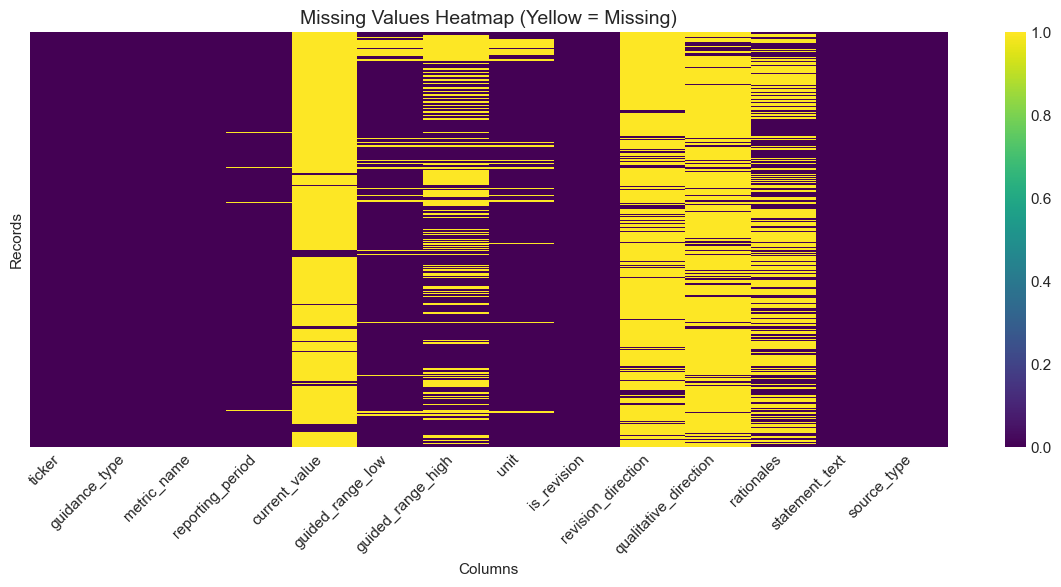

In [9]:
# Visualize missing values heatmap for key columns
key_columns = ['ticker', 'guidance_type', 'metric_name', 'reporting_period',
               'current_value', 'guided_range_low', 'guided_range_high', 'unit',
               'is_revision', 'revision_direction', 'qualitative_direction', 
               'rationales', 'statement_text', 'source_type']

# Filter to columns that exist in dataframe
key_columns = [c for c in key_columns if c in df.columns]

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(df[key_columns].isnull(), cbar=True, yticklabels=False, cmap='viridis', ax=ax)
ax.set_title('Missing Values Heatmap (Yellow = Missing)', fontsize=14)
ax.set_xlabel('Columns')
ax.set_ylabel('Records')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Descriptive Statistics

Summary statistics for numerical columns and value distributions for categorical columns.

In [10]:
# Numerical columns statistics
numerical_cols = ['current_value', 'guided_range_low', 'guided_range_high', 'processing_duration_seconds']
numerical_cols = [c for c in numerical_cols if c in df.columns]

print("Numerical Columns Statistics:\n")
df[numerical_cols].describe().round(2)

Numerical Columns Statistics:



,current_value,guided_range_low,guided_range_high,processing_duration_seconds
count,60.00,748.00,512.00,845.00
mean,1229.36,5585.22,186.01,7.16
std,4957.34,94390.90,955.22,4.86
min,0.10,-650.00,-100.00,4.17
25%,3.13,3.00,3.50,4.98
50%,9.13,10.00,11.95,5.59
75%,229.75,64.62,64.70,6.85
max,27771.00,1800000.00,15400.00,28.98


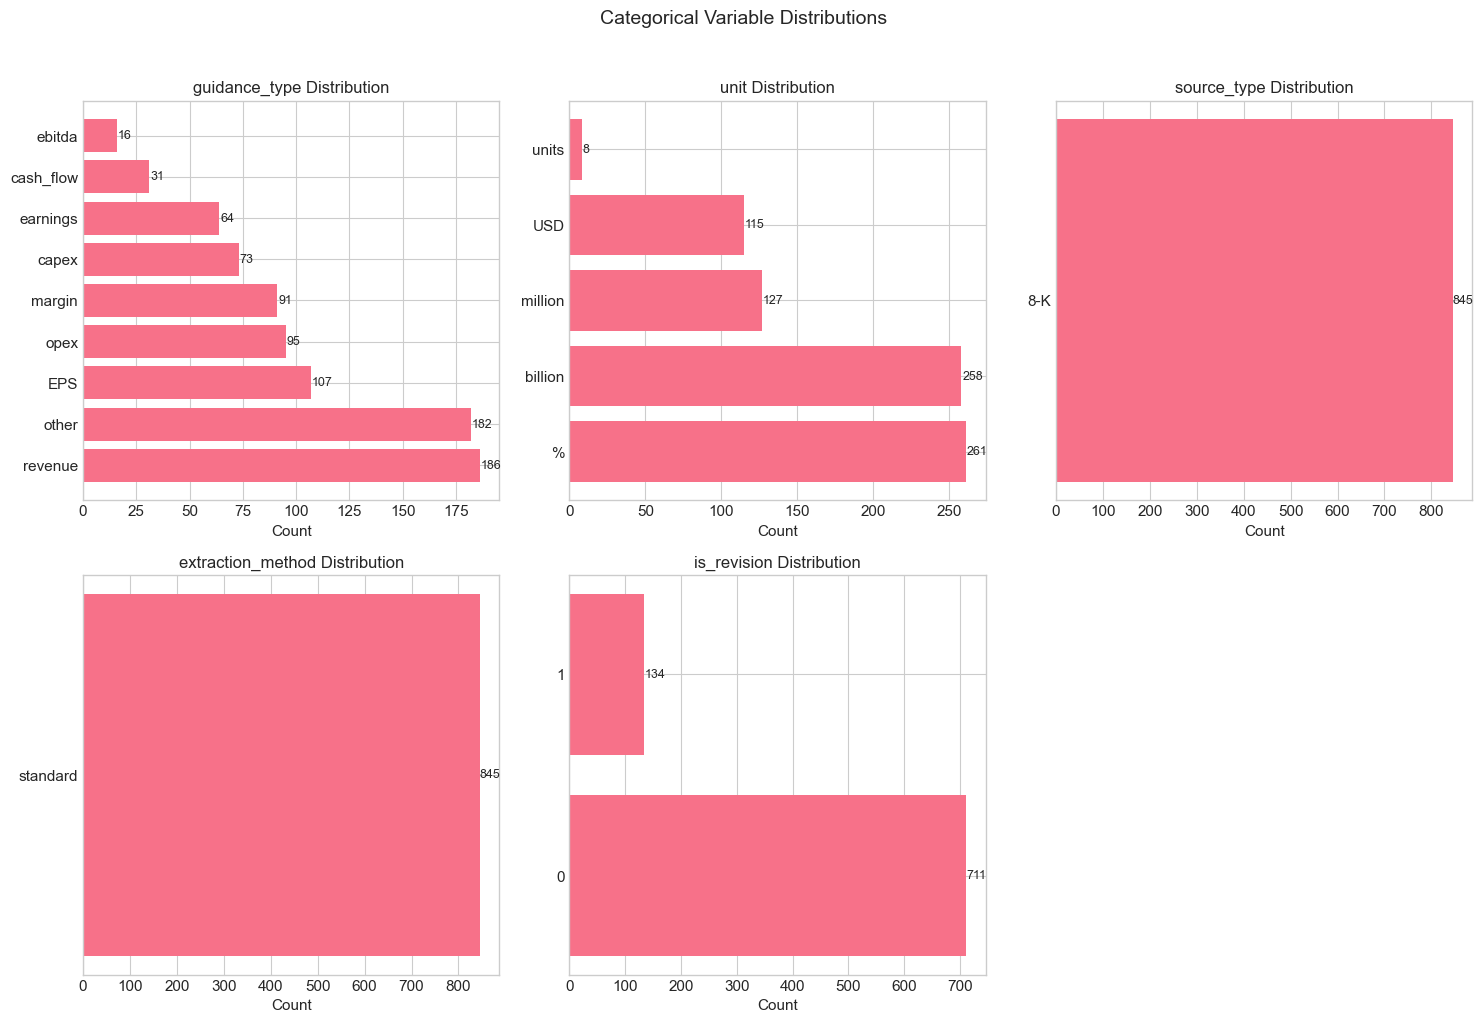

In [11]:
# Categorical columns value counts
categorical_cols = ['guidance_type', 'unit', 'source_type', 'extraction_method', 'is_revision']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        value_counts = df[col].value_counts()
        axes[i].barh(value_counts.index.astype(str), value_counts.values)
        axes[i].set_title(f'{col} Distribution', fontsize=12)
        axes[i].set_xlabel('Count')
        # Add value labels
        for j, v in enumerate(value_counts.values):
            axes[i].text(v + 0.5, j, str(v), va='center', fontsize=9)

# Hide unused subplot
axes[-1].set_visible(False)

plt.suptitle('Categorical Variable Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Distribution Analysis: Guidance Types and Tickers

Deep dive into the distribution of guidance types and company coverage.

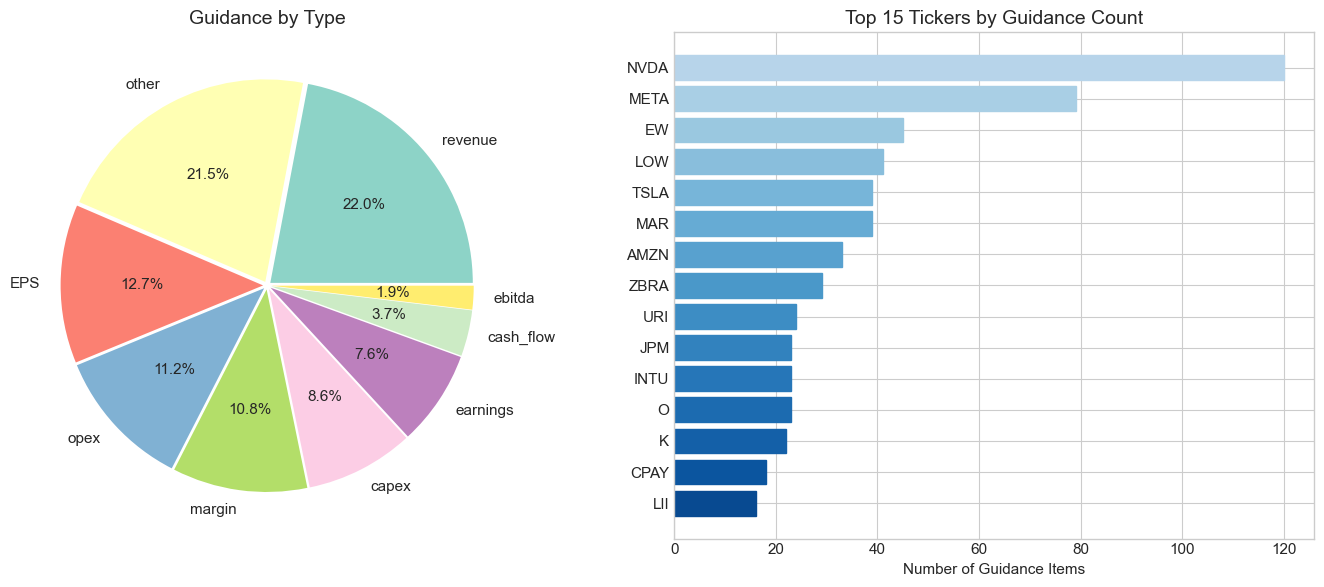


Total unique tickers: 54
Total unique guidance types: 9


In [12]:
# Guidance type distribution - Pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Guidance type pie chart
if 'guidance_type' in df.columns:
    type_counts = df['guidance_type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
    wedges, texts, autotexts = axes[0].pie(
        type_counts.values, 
        labels=type_counts.index, 
        autopct='%1.1f%%',
        colors=colors,
        explode=[0.02] * len(type_counts)
    )
    axes[0].set_title('Guidance by Type', fontsize=14)

# Top 15 tickers bar chart
if 'ticker' in df.columns:
    ticker_counts = df['ticker'].value_counts().head(15)
    bars = axes[1].barh(ticker_counts.index[::-1], ticker_counts.values[::-1])
    axes[1].set_title('Top 15 Tickers by Guidance Count', fontsize=14)
    axes[1].set_xlabel('Number of Guidance Items')
    # Color bars by value
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(ticker_counts)))
    for bar, color in zip(bars, colors[::-1]):
        bar.set_color(color)

plt.tight_layout()
plt.show()

print(f"\nTotal unique tickers: {df['ticker'].nunique()}")
print(f"Total unique guidance types: {df['guidance_type'].nunique()}")

## 7. Temporal Analysis

Analyze guidance extraction patterns over time to identify trends and seasonality.

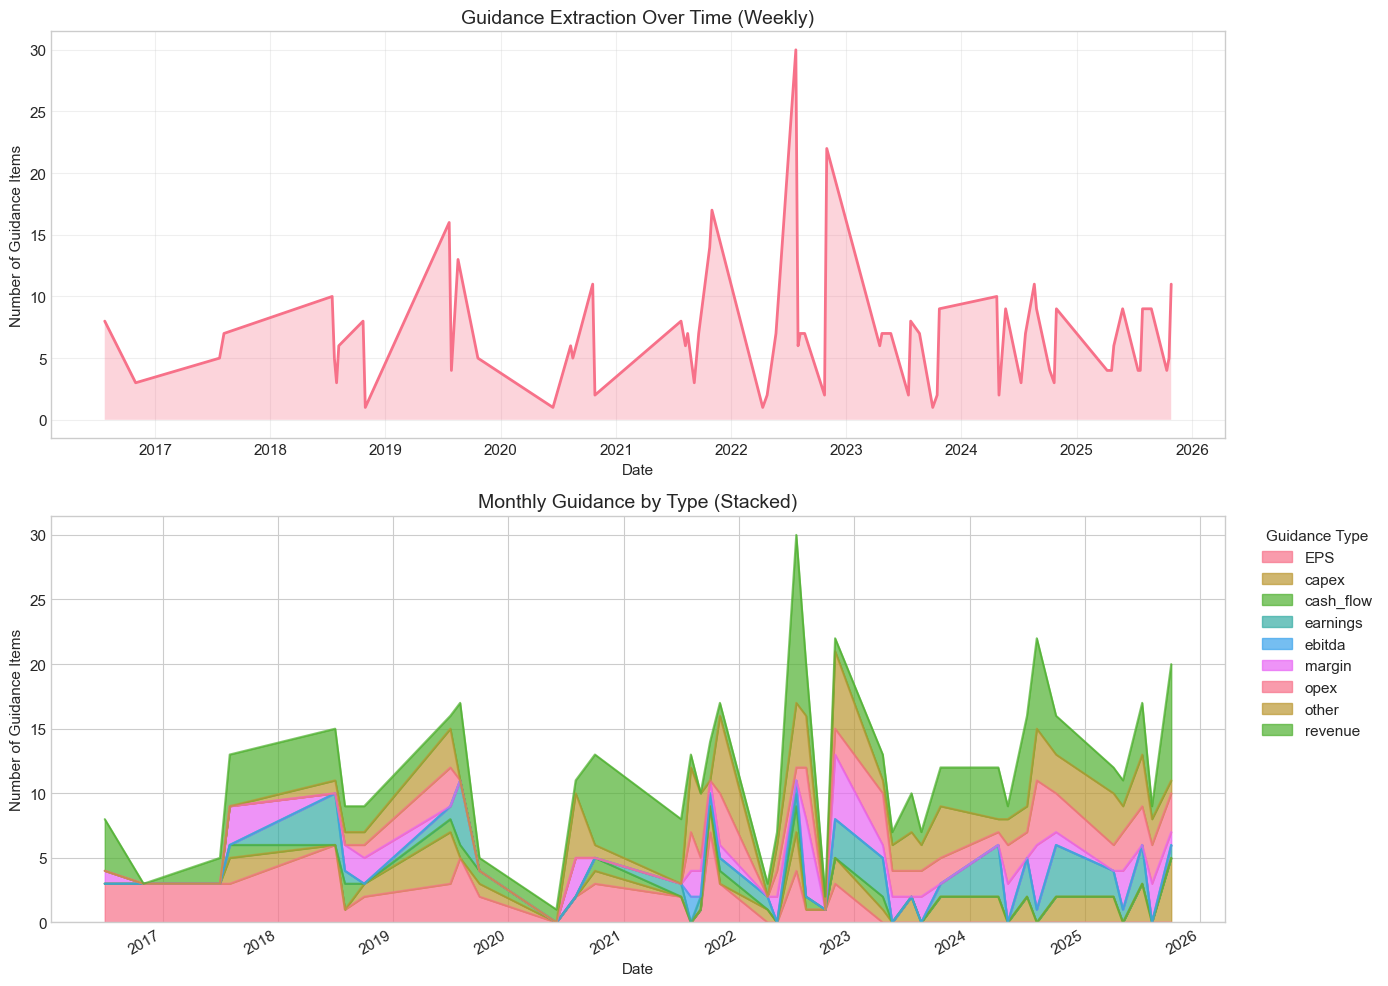


Date range: 2016-07-26 to 2025-10-30


In [14]:
# Time series of guidance extraction
if df['published_at'].notna().any():
    # Filter to valid dates
    df_temporal = df[df['published_at'].notna()].copy()
    
    # Ensure published_at is datetime
    df_temporal['published_at'] = pd.to_datetime(df_temporal['published_at'], errors='coerce')
    df_temporal = df_temporal[df_temporal['published_at'].notna()]
    
    # Group by week
    df_temporal['week'] = df_temporal['published_at'].dt.to_period('W').dt.start_time
    weekly_counts = df_temporal.groupby('week').size()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Weekly trend
    axes[0].fill_between(weekly_counts.index, weekly_counts.values, alpha=0.3)
    axes[0].plot(weekly_counts.index, weekly_counts.values, linewidth=2)
    axes[0].set_title('Guidance Extraction Over Time (Weekly)', fontsize=14)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Number of Guidance Items')
    axes[0].grid(True, alpha=0.3)
    
    # Monthly trend with guidance type breakdown
    df_temporal['month'] = df_temporal['published_at'].dt.to_period('M').dt.start_time
    monthly_by_type = df_temporal.groupby(['month', 'guidance_type']).size().unstack(fill_value=0)
    
    monthly_by_type.plot(kind='area', stacked=True, ax=axes[1], alpha=0.7)
    axes[1].set_title('Monthly Guidance by Type (Stacked)', fontsize=14)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Number of Guidance Items')
    axes[1].legend(title='Guidance Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDate range: {df_temporal['published_at'].min().date()} to {df_temporal['published_at'].max().date()}")
else:
    print("No valid published_at dates found for temporal analysis")

Top 20 Reporting Periods:



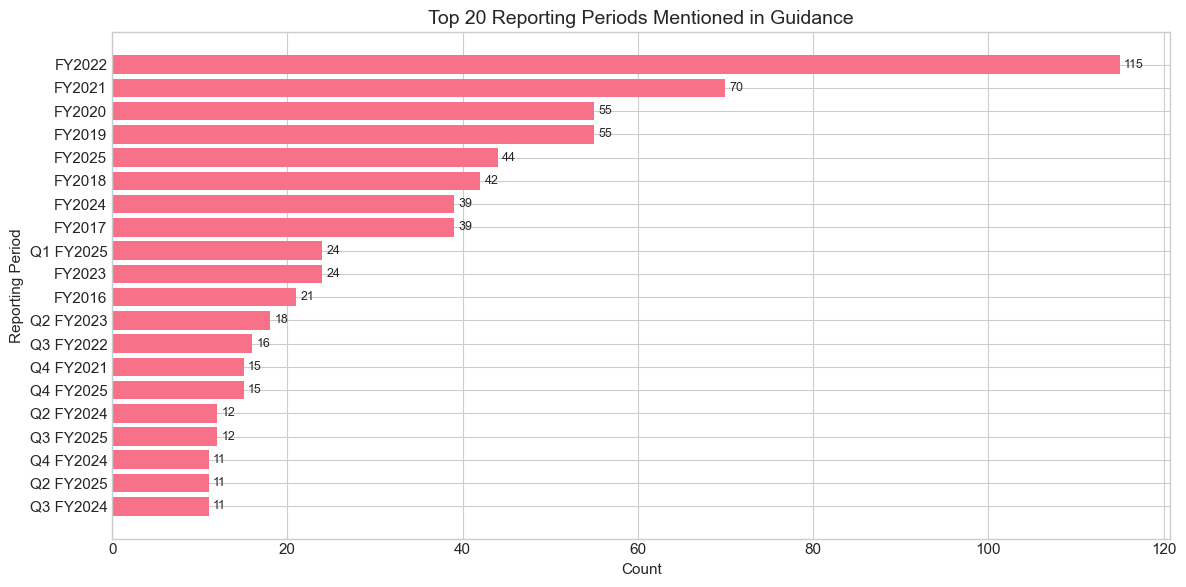

In [15]:
# Reporting period analysis
if 'reporting_period' in df.columns:
    print("Top 20 Reporting Periods:\n")
    period_counts = df['reporting_period'].value_counts().head(20)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(period_counts.index[::-1], period_counts.values[::-1])
    ax.set_title('Top 20 Reporting Periods Mentioned in Guidance', fontsize=14)
    ax.set_xlabel('Count')
    ax.set_ylabel('Reporting Period')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 8. Quantitative Analysis: Guidance Ranges

Analyze the distribution and characteristics of numerical guidance values.

Records with guidance ranges: 511 (60.5%)



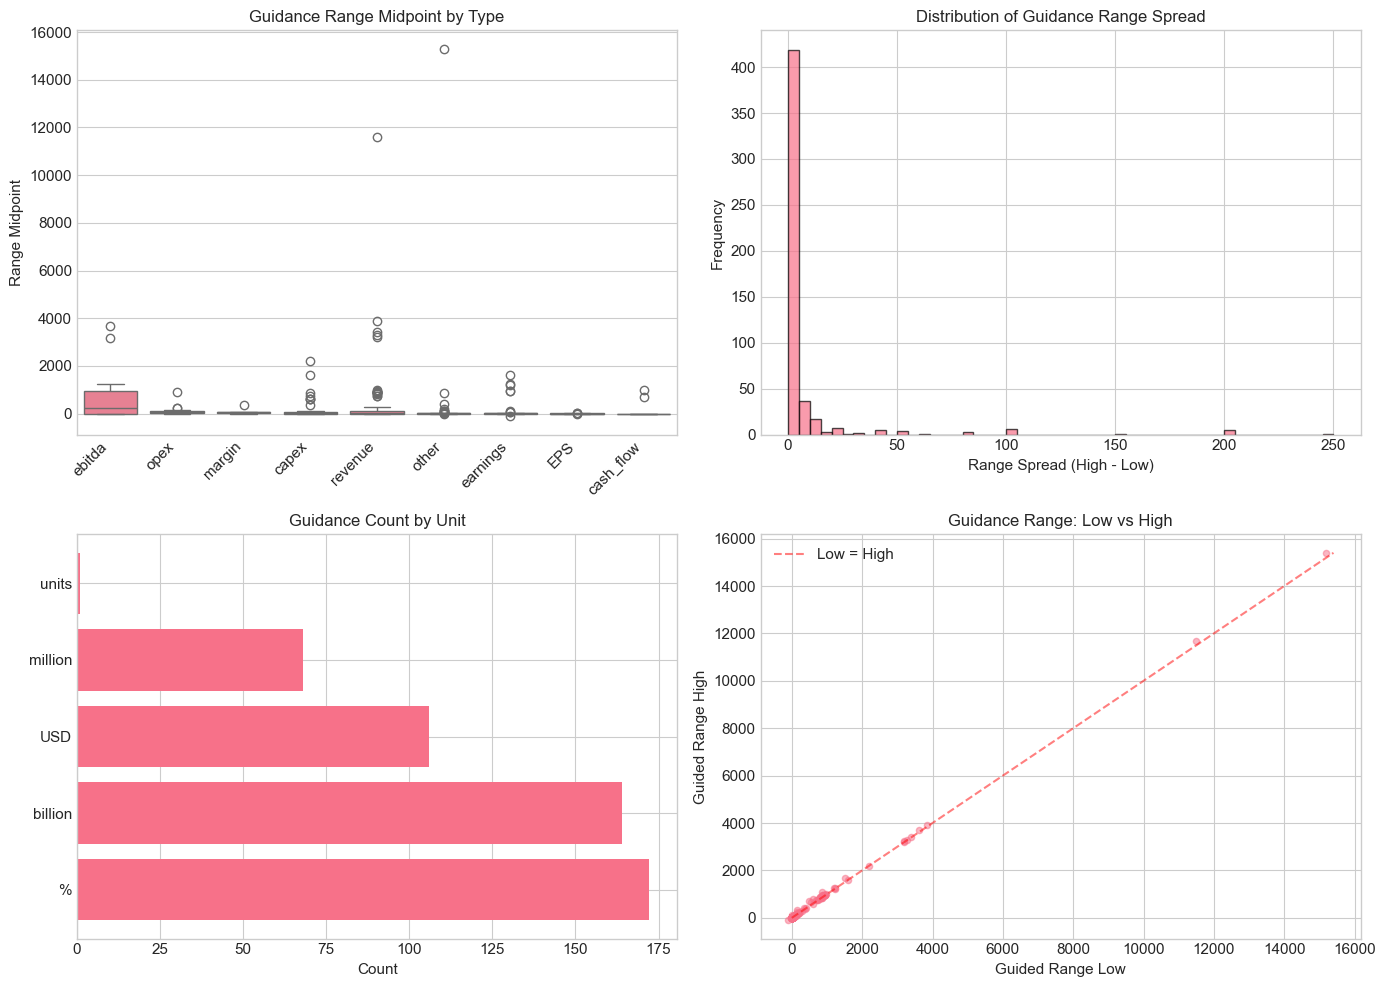

In [16]:
# Calculate range spread (difference between high and low)
df['range_spread'] = df['guided_range_high'] - df['guided_range_low']
df['range_midpoint'] = (df['guided_range_high'] + df['guided_range_low']) / 2

# Filter to records with valid ranges
df_with_ranges = df[(df['guided_range_low'].notna()) & (df['guided_range_high'].notna())].copy()

print(f"Records with guidance ranges: {len(df_with_ranges):,} ({len(df_with_ranges)/len(df)*100:.1f}%)\n")

# Distribution of range spreads by unit
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Range spread distribution
if len(df_with_ranges) > 0:
    # Box plot of range values by guidance type
    axes[0, 0].set_title('Guidance Range Midpoint by Type', fontsize=12)
    df_plot = df_with_ranges[df_with_ranges['range_midpoint'].notna()]
    if len(df_plot) > 0:
        type_order = df_plot.groupby('guidance_type')['range_midpoint'].median().sort_values(ascending=False).index
        sns.boxplot(data=df_plot, x='guidance_type', y='range_midpoint', 
                    order=type_order, ax=axes[0, 0])
        axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
        axes[0, 0].set_ylabel('Range Midpoint')
        axes[0, 0].set_xlabel('')

    # Range spread histogram
    axes[0, 1].hist(df_with_ranges['range_spread'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribution of Guidance Range Spread', fontsize=12)
    axes[0, 1].set_xlabel('Range Spread (High - Low)')
    axes[0, 1].set_ylabel('Frequency')

    # Range values by unit type
    if 'unit' in df_with_ranges.columns:
        unit_stats = df_with_ranges.groupby('unit').agg({
            'range_midpoint': ['mean', 'median', 'count']
        }).round(2)
        unit_stats.columns = ['Mean', 'Median', 'Count']
        unit_stats = unit_stats.sort_values('Count', ascending=False)
        
        axes[1, 0].barh(unit_stats.index, unit_stats['Count'])
        axes[1, 0].set_title('Guidance Count by Unit', fontsize=12)
        axes[1, 0].set_xlabel('Count')
        
    # Scatter: Low vs High range
    axes[1, 1].scatter(df_with_ranges['guided_range_low'], 
                       df_with_ranges['guided_range_high'], 
                       alpha=0.5, s=20)
    # Add diagonal line
    max_val = max(df_with_ranges['guided_range_high'].max(), df_with_ranges['guided_range_low'].max())
    axes[1, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Low = High')
    axes[1, 1].set_title('Guidance Range: Low vs High', fontsize=12)
    axes[1, 1].set_xlabel('Guided Range Low')
    axes[1, 1].set_ylabel('Guided Range High')
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 9. Outlier Detection

Identify potential outliers and anomalies in the extracted data.

In [17]:
# IQR-based outlier detection for numerical columns
def detect_outliers_iqr(series):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analyze outliers in key numerical fields
outlier_summary = []
numerical_fields = ['guided_range_low', 'guided_range_high', 'range_spread', 'processing_duration_seconds']

for col in numerical_fields:
    if col in df.columns and df[col].notna().any():
        outliers, lb, ub = detect_outliers_iqr(df[col].dropna())
        outlier_summary.append({
            'Column': col,
            'Total Values': df[col].notna().sum(),
            'Outliers': len(outliers),
            'Outlier %': round(len(outliers) / df[col].notna().sum() * 100, 2),
            'Lower Bound': round(lb, 2),
            'Upper Bound': round(ub, 2)
        })

outlier_df = pd.DataFrame(outlier_summary)
print("Outlier Detection Summary (IQR Method):\n")
outlier_df

Outlier Detection Summary (IQR Method):



,Column,Total Values,Outliers,Outlier %,Lower Bound,Upper Bound
0,guided_range_low,748,86,11.50,-89.44,157.06
1,guided_range_high,512,57,11.13,-88.30,156.50
2,range_spread,511,57,11.15,-4.00,7.20
3,processing_duration_seconds,845,93,11.01,2.18,9.65


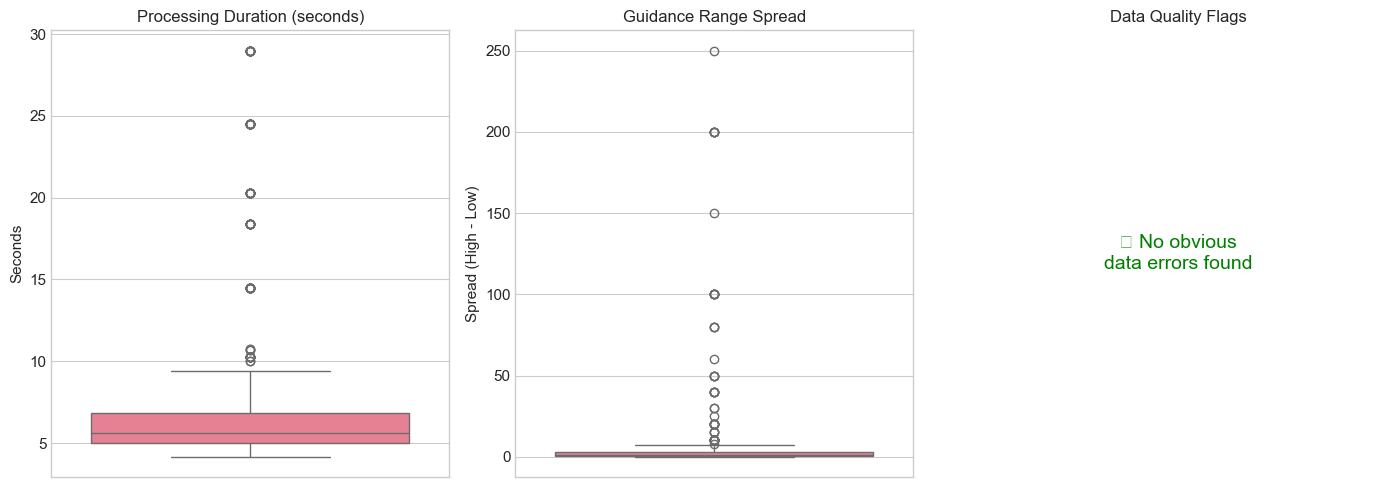

In [18]:
# Box plots for outlier visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Processing duration outliers
if 'processing_duration_seconds' in df.columns:
    sns.boxplot(y=df['processing_duration_seconds'].dropna(), ax=axes[0])
    axes[0].set_title('Processing Duration (seconds)', fontsize=12)
    axes[0].set_ylabel('Seconds')

# Range spread outliers (log scale for better visualization)
if 'range_spread' in df.columns and df['range_spread'].notna().any():
    spread_data = df['range_spread'].dropna()
    spread_data = spread_data[spread_data > 0]  # Filter positive values for log
    if len(spread_data) > 0:
        sns.boxplot(y=spread_data, ax=axes[1])
        axes[1].set_title('Guidance Range Spread', fontsize=12)
        axes[1].set_ylabel('Spread (High - Low)')

# Identify potentially suspicious records
suspicious = df[
    (df['guided_range_low'] > df['guided_range_high']) |  # Low > High (error)
    (df['range_spread'] < 0) |  # Negative spread
    (df['processing_duration_seconds'] > 120)  # Very long processing
].copy()

if len(suspicious) > 0:
    axes[2].text(0.5, 0.5, f"⚠️ Found {len(suspicious)}\nSuspicious Records", 
                 ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
    axes[2].set_title('Data Quality Flags', fontsize=12)
else:
    axes[2].text(0.5, 0.5, "✓ No obvious\ndata errors found", 
                 ha='center', va='center', fontsize=14, color='green', transform=axes[2].transAxes)
    axes[2].set_title('Data Quality Flags', fontsize=12)

axes[2].axis('off')

plt.tight_layout()
plt.show()

if len(suspicious) > 0:
    print(f"\n⚠️ {len(suspicious)} suspicious records found (Low > High or negative spread)")

## 10. Revision Analysis

Analyze patterns in guidance revisions (updates to prior guidance).

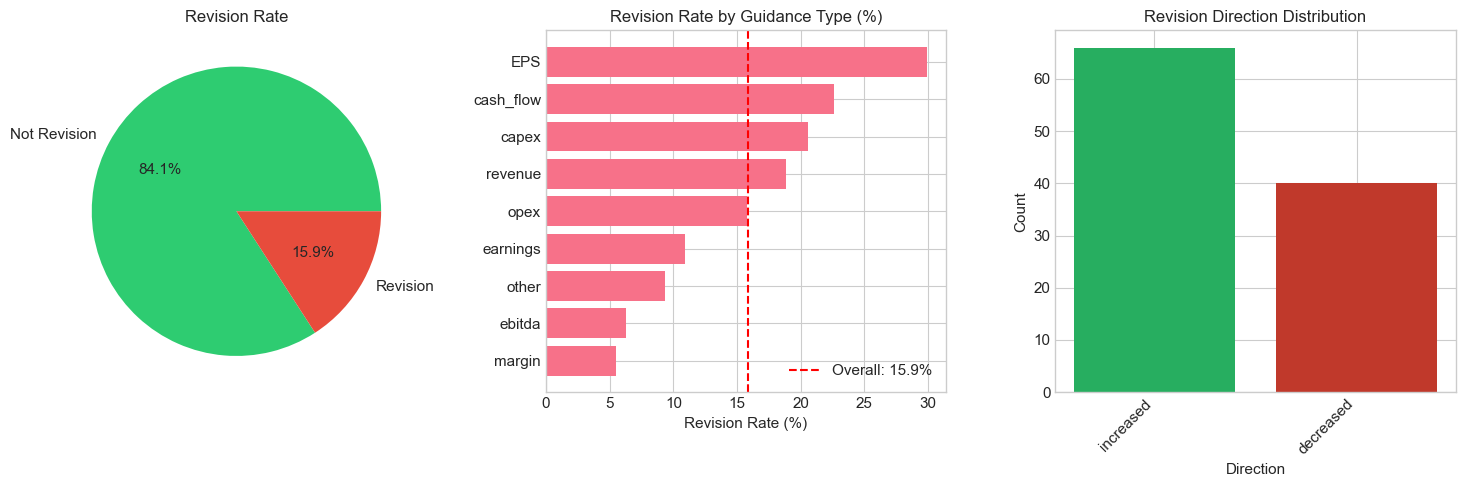


Total revisions: 134 (15.9% of all guidance)


In [19]:
# Revision analysis
if 'is_revision' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Overall revision rate
    revision_counts = df['is_revision'].value_counts()
    labels = ['Not Revision', 'Revision']
    colors = ['#2ecc71', '#e74c3c']
    axes[0].pie(revision_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
    axes[0].set_title('Revision Rate', fontsize=12)
    
    # Revision rate by guidance type
    if 'guidance_type' in df.columns:
        revision_by_type = df.groupby('guidance_type')['is_revision'].mean() * 100
        revision_by_type = revision_by_type.sort_values(ascending=True)
        
        bars = axes[1].barh(revision_by_type.index, revision_by_type.values)
        axes[1].set_title('Revision Rate by Guidance Type (%)', fontsize=12)
        axes[1].set_xlabel('Revision Rate (%)')
        axes[1].axvline(x=df['is_revision'].mean() * 100, color='red', linestyle='--', 
                        label=f'Overall: {df["is_revision"].mean()*100:.1f}%')
        axes[1].legend()
    
    # Revision direction distribution
    if 'revision_direction' in df.columns:
        revisions = df[df['is_revision'] == True]
        if len(revisions) > 0:
            direction_counts = revisions['revision_direction'].value_counts()
            colors = ['#27ae60' if 'increase' in str(d).lower() else '#c0392b' 
                     for d in direction_counts.index]
            axes[2].bar(direction_counts.index.astype(str), direction_counts.values, color=colors)
            axes[2].set_title('Revision Direction Distribution', fontsize=12)
            axes[2].set_xlabel('Direction')
            axes[2].set_ylabel('Count')
            plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal revisions: {df['is_revision'].sum():,} ({df['is_revision'].mean()*100:.1f}% of all guidance)")

## 11. Data Quality Metrics Summary

Comprehensive data quality assessment to determine if the pipeline output is "decent looking".

In [23]:
# Comprehensive data quality metrics
quality_metrics = {
    'Total Records': len(df),
    'Unique Tickers': df['ticker'].nunique(),
    'Unique Guidance Types': df['guidance_type'].nunique() if 'guidance_type' in df.columns else 'N/A',
    'Date Range': f"{df['published_at'].min().date() if df['published_at'].notna().any() else 'N/A'} to {df['published_at'].max().date() if df['published_at'].notna().any() else 'N/A'}",
}

# Completeness metrics
completeness = {
    'Ticker': df['ticker'].notna().mean() * 100,
    'Guidance Type': df['guidance_type'].notna().mean() * 100 if 'guidance_type' in df.columns else 0,
    'Metric Name': df['metric_name'].notna().mean() * 100 if 'metric_name' in df.columns else 0,
    'Reporting Period': df['reporting_period'].notna().mean() * 100 if 'reporting_period' in df.columns else 0,
    'Range Low': df['guided_range_low'].notna().mean() * 100 if 'guided_range_low' in df.columns else 0,
    'Range High': df['guided_range_high'].notna().mean() * 100 if 'guided_range_high' in df.columns else 0,
    'Unit': df['unit'].notna().mean() * 100 if 'unit' in df.columns else 0,
    'Statement Text': df['statement_text'].notna().mean() * 100 if 'statement_text' in df.columns else 0,
}

print("=" * 60)
print("PIPELINE OUTPUT QUALITY SUMMARY")
print("=" * 60)
print("\n📊 Dataset Overview:")
for k, v in quality_metrics.items():
    print(f"   {k}: {v}")

print("\n✅ Field Completeness (% non-null):")
for k, v in completeness.items():
    status = "✓" if v >= 80 else "⚠" if v >= 50 else "✗"
    print(f"   {status} {k}: {v:.1f}%")

# Overall quality score
avg_completeness = np.mean(list(completeness.values()))
print(f"\n📈 Average Field Completeness: {avg_completeness:.1f}%")
print("=" * 60)

PIPELINE OUTPUT QUALITY SUMMARY

📊 Dataset Overview:
   Total Records: 845
   Unique Tickers: 54
   Unique Guidance Types: 9
   Date Range: 2016-02-02 to 2025-10-30

✅ Field Completeness (% non-null):
   ✓ Ticker: 100.0%
   ✓ Guidance Type: 100.0%
   ✓ Metric Name: 100.0%
   ✓ Reporting Period: 98.5%
   ✓ Range Low: 88.5%
   ⚠ Range High: 60.6%
   ✓ Unit: 91.0%
   ✓ Statement Text: 100.0%

📈 Average Field Completeness: 92.3%


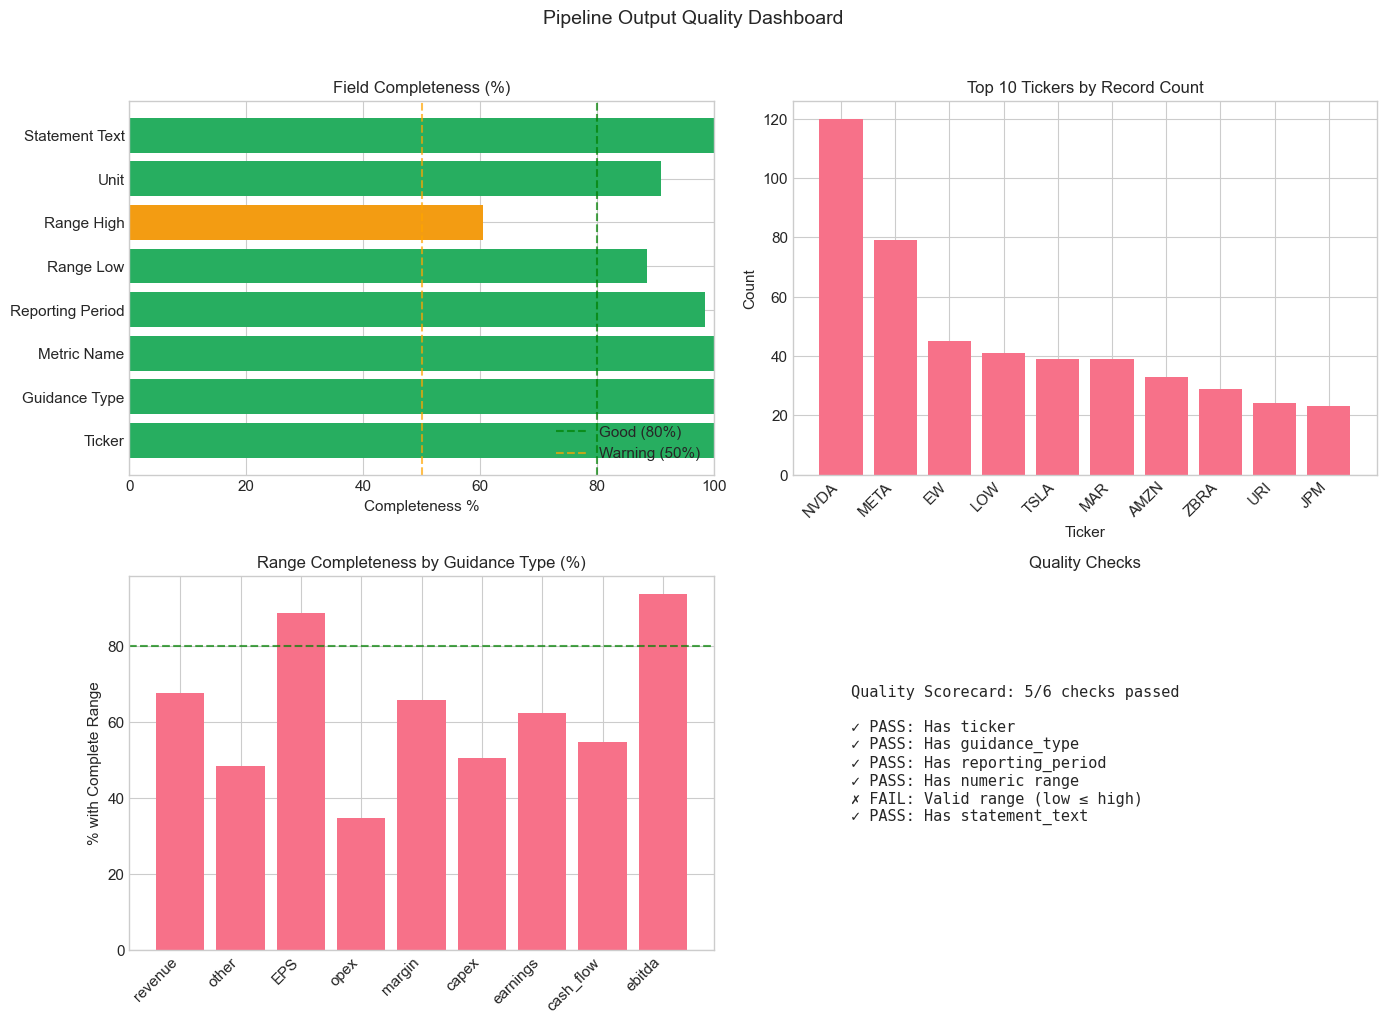

In [24]:
# Visual quality dashboard
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Completeness bar chart
completeness_df = pd.DataFrame(list(completeness.items()), columns=['Field', 'Completeness'])
colors = ['#27ae60' if v >= 80 else '#f39c12' if v >= 50 else '#e74c3c' 
          for v in completeness_df['Completeness']]
bars = axes[0, 0].barh(completeness_df['Field'], completeness_df['Completeness'], color=colors)
axes[0, 0].axvline(x=80, color='green', linestyle='--', alpha=0.7, label='Good (80%)')
axes[0, 0].axvline(x=50, color='orange', linestyle='--', alpha=0.7, label='Warning (50%)')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_title('Field Completeness (%)', fontsize=12)
axes[0, 0].set_xlabel('Completeness %')
axes[0, 0].legend(loc='lower right')

# 2. Records per ticker (top 10)
ticker_counts = df['ticker'].value_counts().head(10)
axes[0, 1].bar(ticker_counts.index, ticker_counts.values)
axes[0, 1].set_title('Top 10 Tickers by Record Count', fontsize=12)
axes[0, 1].set_xlabel('Ticker')
axes[0, 1].set_ylabel('Count')
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Guidance type quality (completeness of ranges by type)
if 'guidance_type' in df.columns:
    type_quality = df.groupby('guidance_type').apply(
        lambda x: pd.Series({
            'Range Complete': (x['guided_range_low'].notna() & x['guided_range_high'].notna()).mean() * 100,
            'Count': len(x)
        })
    )
    type_quality = type_quality.sort_values('Count', ascending=False)
    
    x_pos = np.arange(len(type_quality))
    axes[1, 0].bar(x_pos, type_quality['Range Complete'])
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(type_quality.index, rotation=45, ha='right')
    axes[1, 0].set_title('Range Completeness by Guidance Type (%)', fontsize=12)
    axes[1, 0].set_ylabel('% with Complete Range')
    axes[1, 0].axhline(y=80, color='green', linestyle='--', alpha=0.7)

# 4. Quality summary scorecard
quality_checks = {
    'Has ticker': df['ticker'].notna().mean() >= 0.95,
    'Has guidance_type': df['guidance_type'].notna().mean() >= 0.95 if 'guidance_type' in df.columns else False,
    'Has reporting_period': df['reporting_period'].notna().mean() >= 0.70 if 'reporting_period' in df.columns else False,
    'Has numeric range': ((df['guided_range_low'].notna()) | (df['guided_range_high'].notna())).mean() >= 0.50,
    'Valid range (low ≤ high)': (df['guided_range_low'] <= df['guided_range_high']).mean() >= 0.95 if 'guided_range_low' in df.columns else True,
    'Has statement_text': df['statement_text'].notna().mean() >= 0.80 if 'statement_text' in df.columns else False,
}

passed = sum(quality_checks.values())
total = len(quality_checks)

# Create scorecard text
scorecard_text = f"Quality Scorecard: {passed}/{total} checks passed\n\n"
for check, passed_check in quality_checks.items():
    status = "✓ PASS" if passed_check else "✗ FAIL"
    scorecard_text += f"{status}: {check}\n"

axes[1, 1].text(0.1, 0.5, scorecard_text, fontsize=11, family='monospace',
                verticalalignment='center', transform=axes[1, 1].transAxes)
axes[1, 1].set_title('Quality Checks', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('Pipeline Output Quality Dashboard', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 13. Sample Records Inspection

Examine a random sample of records to qualitatively assess extraction quality.

In [25]:
# Display random sample of well-populated records for qualitative inspection
sample_cols = ['ticker', 'guidance_type', 'metric_name', 'reporting_period', 
               'guided_range_low', 'guided_range_high', 'unit', 'is_revision', 'source_type']
sample_cols = [c for c in sample_cols if c in df.columns]

# Get records with complete key fields
complete_records = df[
    df['ticker'].notna() & 
    df['guidance_type'].notna() & 
    df['guided_range_low'].notna()
]

print(f"Sample of {min(10, len(complete_records))} well-populated records:\n")
complete_records[sample_cols].sample(min(10, len(complete_records)), random_state=42)

Sample of 10 well-populated records:



,ticker,guidance_type,metric_name,reporting_period,guided_range_low,guided_range_high,unit,is_revision,source_type
665,INTU,EPS,GAAP diluted earnings per share,FY2020,6.35,6.45,USD,0,8-K
433,LOW,other,Comparable sales,FY2019,3.00,NaN,%,0,8-K
171,NVDA,other,GAAP tax rate,Q2 FY2023,11.50,13.50,%,0,8-K
309,JPM,opex,adjusted expense,FY2024,92.00,NaN,billion,0,8-K
370,EW,EPS,adjusted EPS,FY2021,2.27,NaN,USD,1,8-K
467,MAR,ebitda,adjusted EBITDA,Q4 FY2017,762.00,777.00,million,0,8-K
413,LOW,EPS,Diluted earnings per share,Q4 FY2020,1.10,1.20,USD,0,8-K
193,AMZN,revenue,Net sales,Q4 FY2023,160.00,167.00,billion,0,8-K
612,EQR,capex,Consolidated rental acquisitions,FY2016,600.00,600.00,million,0,8-K
831,ZBRA,cash_flow,free cash flow,FY2018,525.00,NaN,million,0,8-K


In [26]:
# Examine a single record in detail with its source text
if 'statement_text' in df.columns and len(complete_records) > 0:
    sample_record = complete_records.sample(1, random_state=123).iloc[0]
    
    print("=" * 70)
    print("DETAILED RECORD INSPECTION")
    print("=" * 70)
    print(f"\n📌 Ticker: {sample_record.get('ticker', 'N/A')}")
    print(f"📊 Type: {sample_record.get('guidance_type', 'N/A')}")
    print(f"📋 Metric: {sample_record.get('metric_name', 'N/A')}")
    print(f"📅 Period: {sample_record.get('reporting_period', 'N/A')}")
    print(f"💰 Range: {sample_record.get('guided_range_low', 'N/A')} - {sample_record.get('guided_range_high', 'N/A')} {sample_record.get('unit', '')}")
    print(f"🔄 Revision: {sample_record.get('is_revision', 'N/A')}")
    print(f"📁 Source Type: {sample_record.get('source_type', 'N/A')}")
    print(f"\n📝 Statement Text:\n")
    
    statement = sample_record.get('statement_text', 'N/A')
    if isinstance(statement, str) and len(statement) > 500:
        print(statement[:500] + "...")
    else:
        print(statement)
    print("=" * 70)

DETAILED RECORD INSPECTION

📌 Ticker: NVDA
📊 Type: opex
📋 Metric: non-GAAP operating expenses
📅 Period: Q3 FY2022
💰 Range: 1.37 - nan billion
🔄 Revision: 0
📁 Source Type: 8-K

📝 Statement Text:

Q1 FY22
Q2 FY21
Q/Q
Y/Y
Revenue
$6,507
$5,661
$3,866
Up 15%
Up 68%
Gross margin
66.7
%
66.2
%
66.0
%
Up 50 bps
Up 70 bps
Operating expenses
$1,266
$1,189
$1,035
Up 6%
Up 22%
Operating income
$3,071
$2,557
$1,516
Up 20%
Up 103%
Net income
$2,623
$2,313
$1,366
Up 13%
Up 92%
Diluted earnings per share
$1.04
$0.91
$0.55
Up 14%
Up 89%
NVIDIA’s outlook for the third quarter of fiscal 2022 is as follows:
•
Revenue is expected to be $6.80 billion, plus or minus 2 percent.
•
GAAP and non-GAAP gross margi...


## 14. Conclusions and Next Steps

Summary of EDA findings and recommendations for pipeline improvement.

In [27]:
# Generate summary statistics for thesis
summary = f"""
================================================================================
                    EDA SUMMARY FOR THESIS DOCUMENTATION
================================================================================

DATASET OVERVIEW:
- Total guidance records extracted: {len(df):,}
- Unique companies (tickers): {df['ticker'].nunique()}
- Guidance types covered: {df['guidance_type'].nunique() if 'guidance_type' in df.columns else 'N/A'}
- Date range: {df['published_at'].min().date() if df['published_at'].notna().any() else 'N/A'} to {df['published_at'].max().date() if df['published_at'].notna().any() else 'N/A'}

DATA COMPLETENESS:
- Average field completeness: {avg_completeness:.1f}%
- Records with numeric guidance ranges: {((df['guided_range_low'].notna()) | (df['guided_range_high'].notna())).sum():,} ({((df['guided_range_low'].notna()) | (df['guided_range_high'].notna())).mean()*100:.1f}%)
- Records with statement text: {df['statement_text'].notna().sum() if 'statement_text' in df.columns else 'N/A'}

QUALITY INDICATORS:
- Quality checks passed: {passed}/{total}
- Revision rate: {df['is_revision'].mean()*100:.1f}% (indicates pipeline captures updates)
- Average processing time: {df['processing_duration_seconds'].mean():.1f}s per record

NEXT STEPS FOR THESIS:
1. Compare extracted guidance against ground truth (separate evaluation section)
2. Analyze extraction errors for common failure patterns
3. Document pipeline strengths and limitations
4. Consider field-level accuracy metrics (precision, recall, F1)
================================================================================
"""

print(summary)


                    EDA SUMMARY FOR THESIS DOCUMENTATION

DATASET OVERVIEW:
- Total guidance records extracted: 845
- Unique companies (tickers): 54
- Guidance types covered: 9
- Date range: 2016-02-02 to 2025-10-30

DATA COMPLETENESS:
- Average field completeness: 92.3%
- Records with numeric guidance ranges: 749 (88.6%)
- Records with statement text: 845

QUALITY INDICATORS:
- Quality checks passed: 5/6
- Revision rate: 15.9% (indicates pipeline captures updates)
- Average processing time: 7.2s per record

NEXT STEPS FOR THESIS:
1. Compare extracted guidance against ground truth (separate evaluation section)
2. Analyze extraction errors for common failure patterns
3. Document pipeline strengths and limitations
4. Consider field-level accuracy metrics (precision, recall, F1)



In [ ]:
# Close database connection
conn.close()
print("Database connection closed.")